In [10]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
import math


In [11]:
model_name = "model_large-d1-DWConv"
img_width = 200
img_height = 66
img_channels = 3
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)

In [12]:
import zipfile
!wget --no-check-certificate --no-clobber https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Dataset.zip
zip_ref = zipfile.ZipFile('Dataset.zip')
zip_ref.extractall('Dataset')

File ‘Dataset.zip’ already there; not retrieving.



In [13]:
from keras import layers

model = tf.keras.Sequential()
model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

In [14]:
# Train/test data lists
imgs = []
vals = []

# Load all train/test data into their respective lists
for i in range(11):
    vid_file_path = "Dataset/out-video-{}.avi".format(i)
    csv_file_path = "Dataset/out-key-{}.csv".format(i)
    vid = cv2.VideoCapture(vid_file_path)
    ret,img = vid.read()
    while(ret):
        # Convert to grayscale and readd channel dimension
        if img_channels == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_width, img_height))
            img = np.reshape(img, (img_height, img_width, img_channels))
        # For RGB, just need to resize image
        else:
            img = cv2.resize(img, (img_width, img_height))
        img = img / 255.
        imgs.append(img)
        ret,img = vid.read()
    df = read_csv(csv_file_path)
    temp = np.asarray(df["wheel"].values)
    vals.extend(temp)
    # print(len(imgs), len(vals))    

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))


Loaded 11000 smaples


In [15]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)

Train/Test


In [16]:
#print(x_train[0])
print ("Model compile")
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss='mse', metrics=['mae'])

Model compile


Model fit
Epoch 1/10
83/83 [==============================] - 17s 194ms/step - loss: 0.1030 - mae: 0.2702 - val_loss: 0.0777 - val_mae: 0.2364
Epoch 2/10
83/83 [==============================] - 12s 148ms/step - loss: 0.0730 - mae: 0.2179 - val_loss: 0.0678 - val_mae: 0.2065
Epoch 3/10
83/83 [==============================] - 12s 144ms/step - loss: 0.0664 - mae: 0.2042 - val_loss: 0.0625 - val_mae: 0.2005
Epoch 4/10
83/83 [==============================] - 13s 152ms/step - loss: 0.0625 - mae: 0.1962 - val_loss: 0.0603 - val_mae: 0.1997
Epoch 5/10
83/83 [==============================] - 13s 155ms/step - loss: 0.0597 - mae: 0.1911 - val_loss: 0.0586 - val_mae: 0.1897
Epoch 6/10
83/83 [==============================] - 12s 150ms/step - loss: 0.0566 - mae: 0.1850 - val_loss: 0.0624 - val_mae: 0.1908
Epoch 7/10
83/83 [==============================] - 12s 150ms/step - loss: 0.0555 - mae: 0.1844 - val_loss: 0.0588 - val_mae: 0.1943
Epoch 8/10
83/83 [==============================] - 12s 150

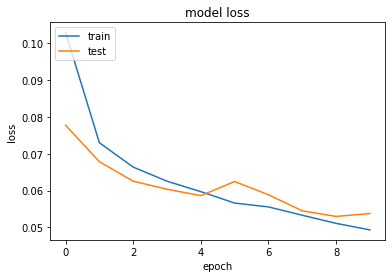

In [17]:
print ("Model fit")
history = model.fit(x_train, y_train, batch_size=100,
                    epochs=10, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Helper functions for evaluating model accuracy
def rad2deg(rad):
  return 180.0 * rad / math.pi
def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < 15 and degree > -15:
    return "center"
  elif degree >= 15:
    return "right" 
  elif degree <-15:
    return "left"

In [19]:
pred = model.predict(x_test)
pred = np.array(list(map(get_action, pred)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

Accuracy is 0.740


In [20]:
# Save both the Keras and TFLite models      
print("Model Save")                  
model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

Model Save
TFLite Model


2022-04-13 16:02:48.379191: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpu40v7cmk/assets


2022-04-13 16:02:55.000251: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-13 16:02:55.000281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-13 16:02:55.012508: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpu40v7cmk
2022-04-13 16:02:55.014824: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-13 16:02:55.014829: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpu40v7cmk
2022-04-13 16:02:55.022293: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-13 16:02:55.082351: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpu40v7cmk
2022-04-